In [22]:
import os
import pandas as pd
import numpy as np
import sklearn
import nilearn
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns

load labels

In [3]:
df_labels = pd.read_csv('./data/labels.csv')
df_labels

,seq,run1,run2,run3,run4
0,1,Cow,Engine,Street,Grass
1,2,Kitchen,Phone,Engine,type
2,3,Grass,Sheep,Cow,Horn
3,4,Fry,Office,Phone,Fry
4,5,Sheep,Horn,Office,Office
5,6,Phone,Street,Fry,Kitchen
6,7,Engine,Cut,Cut,Sheep
7,8,Street,Kitchen,Sheep,Street
8,9,Horn,Fry,Grass,Engine
9,10,Office,Type,Horn,Phone


In [21]:

one_hot_enc = OneHotEncoder(handle_unknown='ignore')
one_hot_enc.fit_transform(df_labels.iloc[:, 1].to_numpy().reshape(-1, 1))

<12x12 sparse matrix of type '<class 'numpy.float64'>'
	with 12 stored elements in Compressed Sparse Row format>

In [24]:
cate_enc = LabelEncoder()
cate_enc.fit_transform(df_labels.iloc[:, 1].to_numpy())

array([ 0,  6,  4,  3,  9,  8,  2, 10,  5,  7,  1, 11])

load data

In [5]:

base_dir = './output/'
subjects = os.listdir(base_dir)
runs = [f'run{i}' for i in range(1, 5)]
WINDOW_SIZE = 19

print('subjects: ', subjects)
print('runs: ', runs)

subjects:  ['Sub017', 'Sub012', 'Sub009', 'Sub015', 'Sub016', 'Sub006', 'Sub023', 'Sub013', 'Sub004', 'Sub002', 'Sub014', 'Sub022', 'Sub003', 'Sub008', 'Sub024', 'Sub010', 'Sub020', 'Sub021', 'Sub011', 'Sub007', 'Sub005']
runs:  ['run1', 'run2', 'run3', 'run4']


In [6]:
ts = np.load('./output/Sub002/run1/merged.npy') 
ts.shape

(228, 164)

In [8]:
from utils.util import ts_windowing, get_correfs

In [9]:
res = ts_windowing(ts, WINDOW_SIZE)
res.shape

(12, 19, 164)

In [10]:
correfs = get_correfs(res, 164)

<AxesSubplot: >

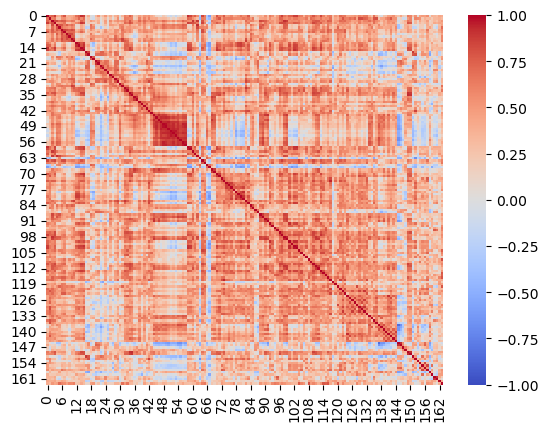

In [20]:
sns.heatmap(correfs[0, :, :], vmin=-1, vmax=1, cmap='coolwarm')

In [29]:
y = cate_enc.transform(df_labels.iloc[:, 1].to_numpy())
X = correfs
print(y.shape)
print(X.shape)

(12,)
(12, 164, 164)


modeling 

In [33]:
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X.reshape((12, 164*164)), y)

KNeighborsClassifier(n_neighbors=1)

In [34]:
knn.predict(X[0, :, :].reshape((1, 164*164)))

array([0])

In [35]:
y

array([ 0,  6,  4,  3,  9,  8,  2, 10,  5,  7,  1, 11])

In [ ]:
df_samples = pd.DataFrame()

In [36]:
X = np.load('./fcns/Xs.npy')

In [39]:
X.shape

(1008, 164, 164)

In [45]:
X_flat = X.reshape((X.shape[0], X.shape[1]*X.shape[2]))

In [40]:
y = np.load('./fcns/ys.npy')
y.shape

(1008,)

In [42]:
from sklearn.model_selection import train_test_split

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X_flat, y, test_size=0.33, random_state=42)

In [60]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)

KNeighborsClassifier(n_neighbors=20)

In [61]:
y_preds = knn.predict(X_test)

In [62]:
from sklearn.metrics import accuracy_score

In [63]:
accuracy_score(y_test, y_preds)

0.09309309309309309

In [64]:
from sklearn import svm

In [65]:
model = svm.SVC()

In [66]:
model.fit(X_train, y_train)

SVC()

In [67]:
y_preds = model.predict(X_test)

In [68]:
accuracy_score(y_test, y_preds)

0.13513513513513514

In [75]:
knn = KNeighborsClassifier(n_neighbors=20)
knn.fit(X_train, y_train)

y_preds = knn.predict(X_test)
accuracy_score(y_test, y_preds)

0.08408408408408409

In [76]:
model = svm.SVC()
model.fit(X_train, y_train)

y_preds = model.predict(X_test)

accuracy_score(y_test, y_preds)

0.12012012012012012

In [94]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [95]:

pipeline = Pipeline([
    ('model', Lasso())
])
search = GridSearchCV(pipeline,
                      {'model__alpha':np.arange(0.1,10,0.1)},
                      cv = 5, scoring="neg_mean_squared_error",verbose=3
                      )

In [96]:
search.fit(X_train, y_train)

Fitting 5 folds for each of 99 candidates, totalling 495 fits
[CV 1/5] END ................model__alpha=0.1;, score=-10.851 total time=   0.2s
[CV 2/5] END ................model__alpha=0.1;, score=-12.088 total time=   0.5s
[CV 3/5] END ................model__alpha=0.1;, score=-10.704 total time=   0.2s
[CV 4/5] END ................model__alpha=0.1;, score=-11.123 total time=   0.3s
[CV 5/5] END ................model__alpha=0.1;, score=-11.473 total time=   0.2s
[CV 1/5] END ................model__alpha=0.2;, score=-11.443 total time=   0.1s
[CV 2/5] END ................model__alpha=0.2;, score=-12.133 total time=   0.5s
[CV 3/5] END ................model__alpha=0.2;, score=-11.280 total time=   0.2s
[CV 4/5] END ................model__alpha=0.2;, score=-11.217 total time=   0.2s
[CV 5/5] END ................model__alpha=0.2;, score=-12.045 total time=   0.3s
[CV 1/5] END model__alpha=0.30000000000000004;, score=-11.561 total time=   0.1s
[CV 2/5] END model__alpha=0.30000000000000004;,

GridSearchCV(cv=5, estimator=Pipeline(steps=[('model', Lasso())]),
             param_grid={'model__alpha': array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1. , 1.1, 1.2, 1.3,
       1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2. , 2.1, 2.2, 2.3, 2.4, 2.5, 2.6,
       2.7, 2.8, 2.9, 3. , 3.1, 3.2, 3.3, 3.4, 3.5, 3.6, 3.7, 3.8, 3.9,
       4. , 4.1, 4.2, 4.3, 4.4, 4.5, 4.6, 4.7, 4.8, 4.9, 5. , 5.1, 5.2,
       5.3, 5.4, 5.5, 5.6, 5.7, 5.8, 5.9, 6. , 6.1, 6.2, 6.3, 6.4, 6.5,
       6.6, 6.7, 6.8, 6.9, 7. , 7.1, 7.2, 7.3, 7.4, 7.5, 7.6, 7.7, 7.8,
       7.9, 8. , 8.1, 8.2, 8.3, 8.4, 8.5, 8.6, 8.7, 8.8, 8.9, 9. , 9.1,
       9.2, 9.3, 9.4, 9.5, 9.6, 9.7, 9.8, 9.9])},
             scoring='neg_mean_squared_error', verbose=3)

In [97]:
search.best_params_

{'model__alpha': 0.1}

In [98]:
coefficients = search.best_estimator_.named_steps['model'].coef_

In [99]:
importance = np.abs(coefficients)

<AxesSubplot: >

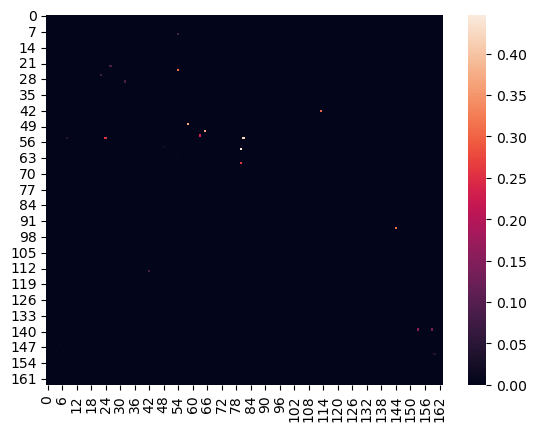

In [101]:
sns.heatmap(importance.reshape((164, 164)))

In [108]:
X_selected = X_flat[:, importance > 0]
X_train, X_test, y_train, y_test = train_test_split(X_selected, y, test_size=0.33, random_state=42)

In [109]:
model = svm.SVC()
model.fit(X_train, y_train)

y_preds = model.predict(X_test)
accuracy_score(y_test, y_preds)

0.15873015873015872